In [60]:
import menzalib as mz
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
from scipy.stats import chi2
from numdifftools.nd_algopy import Derivative
from numpy import sqrt, vectorize, absolute, log, array

In [84]:
def theta(x):
    if x>0: return 1
    return 0

def falfat(V,V0,a,b,I0,alfa):
    return a*theta(V0-V)*np.abs(V0-V)**alfa+b*V+I0
falfa=np.vectorize(falfat)

def f2t(V,V0,a,b,I0):
    return a*theta(V0-V)*(V0-V)**2+b*V+I0
f2=np.vectorize(f2t)

def cifrat(x):
    i=0
    while (x-np.round(x,-i))!=0: i=i-1
    return i
cifra=np.vectorize(cifrat)


array(0)

In [90]:
def curve_fitdx(f, x, y, dx=None, dy=None, p0=None, df=None, nit=10, absolute_sigma=False, chi2pval=False):
    # Inizializzazione variabili, se la derivata
    # non è data esplicitamente la approssimo con scipy
    if dy is None :
        dy = np.ones(len(y))

    if dx is None:
        popt, pcov = curve_fit(f, x, y, p0, dy, absolute_sigma=absolute_sigma)
        chi = np.sum(((f(x,*popt)-y)/dy)**2)
    
    else:
        if df is None:
            df=Derivative(f)
        
        # Eseguo il fit
        sigma_eff = dy
        chi, chi_old = 1, -1
        i=0
        while (i<10 and (chi-chi_old)/chi > 1e-6):
            print(sigma_eff)
            popt, pcov = curve_fit(f, x, y, p0, sigma_eff, absolute_sigma=absolute_sigma)
            sigma_eff = sqrt(dy**2 + (df(x, *popt)*dx)**2)
            print(df(x, *popt)*dx)
            chi_old = chi
            chi = np.sum(((f(x,*popt)-y)/sigma_eff)**2)
            i += 1
            x=np.linspace(0.6,1.3)
            y=f(x,*popt)
            pl.plot(x,-y)
            pl.show()

    if (chi2pval==False):
        return popt, pcov
    else:
        dpopt = sqrt(np.diag(pcov))
        pvalue = chi2.cdf(chi,len(x)-len(popt))
        return popt, pcov, dpopt, chi, pvalue

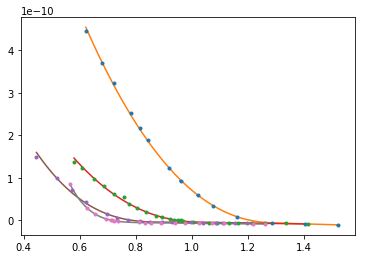

In [94]:
dati=['dati/450nm.txt','dati/499nm.txt','dati/545nm.txt','dati/577nm.txt']
v0=[1.213,0.951,0.774,0.715]
p0=np.zeros((len(dati),5))
for i in range(len(dati)):
    V,I=np.genfromtxt(dati[i],unpack='True')
    I=I*1e-12
    V=V*1e-3
    dV=mz.dVdig(V)
    dI=np.zeros(len(I))
    for j in range(len(I)):
        dI[j]=np.sqrt((I[j]*4e-3)**2+10.0**(cifra(I[j])*2))
        if I[j]==0: dI[j]=1e-13
    p0[i][0]=v0[i]
    p0[i][-1]=2
    
    #il quarto fit con gli errori sulle x non converge
    #popt,pcov=mz.curve_fitdx(falfa,V,I,dV,dI,p0[i])
    popt,pcov=curve_fit(falfa,V,I,sigma=dI,p0=p0[i])
    pl.errorbar(V,-I,xerr=dV,yerr=dI,fmt='.')
    x=np.linspace(V[0],V[-1],100)
    y=falfa(x,*popt)
    pl.plot(x,-y)
pl.show()
